## Using

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
# drive.mount('/gdrive')
%cd /content/drive/MyDrive/github/filter_data

Mounted at /content/drive
/content/drive/MyDrive/github/filter_data


In [ ]:
# %%writefile -a dataprep_utils.py
# !pip install indic-num2words

In [ ]:
import pickle
# import dataprep_utils
import pandas as pd
import numpy as np
import os

def get_data(lang_list):
    # lang = 'en'
    all_data = pd.DataFrame()
    for lang in lang_list:
        read_dir = os.path.join(os.getcwd(),'embedding_data', lang)
        files = os.listdir(read_dir)
        data_files = [file for file in files if file.endswith(".pickle")]

        for file in data_files:
            with open(f'{os.path.join(read_dir, file)}', 'rb') as handle:
                data = pickle.load(handle)
            all_data = pd.concat([all_data, data], ignore_index=True)
    return all_data


def get_pca_components(embedding_features_df, pca_components):
    pca = PCA(n_components=pca_components)
    pca.fit_transform(embedding_features_df)
    #extract the explained variance
    explained_variance = pca.explained_variance_ratio_
    singular_values = pca.singular_values_
    cum_explained_variance = pca.explained_variance_ratio_.cumsum()
    return (explained_variance, singular_values, cum_explained_variance)

In [ ]:
data = get_data(['en'])
embedding_features = [tensor.tolist() for tensor in data.embeddings]
embedding_features_df = pd.DataFrame(embedding_features)
target = data.intent
data.shape

(19134, 4)

In [ ]:
from sklearn.decomposition import PCA
pca_components = 100
pca_result = get_pca_components(embedding_features_df, pca_components)
explained_variance = pca_result[0]
singular_values = pca_result[1]
cum_explained_variance = pca_result[2]

In [ ]:
cum_explained_variance

array([0.21215319, 0.30088695, 0.37397618, 0.41224744, 0.44283574,
       0.46867368, 0.49358586, 0.51547562, 0.53505969, 0.5515778 ,
       0.56678792, 0.58049408, 0.59231075, 0.60337166, 0.61390051,
       0.62383543, 0.63344412, 0.64259205, 0.65096336, 0.65862904,
       0.66607312, 0.67307535, 0.679932  , 0.68648756, 0.692894  ,
       0.69880722, 0.70441256, 0.70978335, 0.7150412 , 0.72024609,
       0.72532958, 0.73016292, 0.73477942, 0.73928365, 0.74368264,
       0.74781994, 0.75182262, 0.75564141, 0.75936403, 0.76305609,
       0.7667093 , 0.77014747, 0.7734089 , 0.7766513 , 0.77973709,
       0.78273125, 0.78566929, 0.78855101, 0.79138721, 0.79412939])

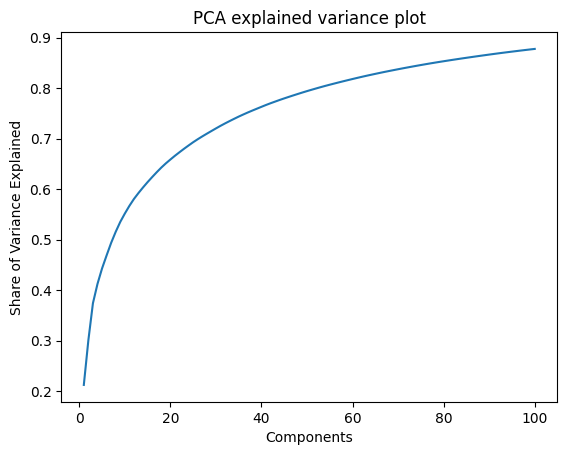

In [ ]:
import matplotlib.pyplot as plt
#create an x for each component
x = np.arange(1,len(explained_variance)+1)
#plot the results
# plt.plot(x, explained_variance)
plt.plot(x, cum_explained_variance)
#add a y label
plt.ylabel('Share of Variance Explained')
plt.title("PCA explained variance plot")
plt.xlabel("Components")
#show the resulting plot
plt.show()

In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import cross_val_score

rf_100 = RandomForestClassifier(random_state = 0)
rf_150 = RandomForestClassifier(n_estimators = 150, random_state = 0)
rf_200 = RandomForestClassifier(n_estimators = 200, random_state = 0)
# rf_250 = RandomForestClassifier(n_estimators = 250, random_state = 0)
# gb = GradientBoostingClassifier(n_estimators=300, max_depth=2, random_state = 0)

X_train, X_test, y_train, y_test = train_test_split(embedding_features_df, data.intent, test_size=0.10, stratify=data.intent, random_state=47)

### Random Forest

In [ ]:
from imblearn.over_sampling import RandomOverSampler
from imblearn.pipeline import Pipeline
from sklearn.decomposition import PCA

clf_list = list()
for algo in [rf_150, rf_200]:
    clf = Pipeline(steps = [('RUS', RandomOverSampler()),
                            ('PCA', PCA(n_components=pca_components)),
                            ('algo', algo)])

    clf = clf.fit(X_train, y_train)
    clf_list.append(clf)
    print(f'Train Score using {algo}: {clf.score(X_train, y_train)}')
    print(f'Test Score using {algo}: {clf.score(X_test, y_test)}\n')

Train Score using RandomForestClassifier(n_estimators=150, random_state=0): 1.0
Test Score using RandomForestClassifier(n_estimators=150, random_state=0): 0.9791013584117032

Train Score using RandomForestClassifier(n_estimators=200, random_state=0): 1.0
Test Score using RandomForestClassifier(n_estimators=200, random_state=0): 0.9811912225705329



In [ ]:
# X_test.head()

,0,1,2,3,4,5,6,7,8,9,...,759,760,761,762,763,764,765,766,767,predictions
179,-0.030363,0.016988,0.000574,-0.000361,0.116318,-0.104121,0.082608,-0.071345,0.103418,0.128223,...,0.020528,0.025545,-0.162225,0.010956,0.022872,0.020909,0.005960,-0.047661,0.232633,fastag_recharge
1521,-0.189315,-0.040935,0.003535,0.019341,0.049160,-0.012920,0.092146,0.074742,-0.089020,0.009338,...,-0.070752,0.061786,-0.004980,0.006391,0.014876,0.120532,0.170787,0.115288,0.197375,p2p_transfer
2350,-0.047671,0.003592,-0.177122,-0.149469,-0.008352,0.036227,-0.121881,0.163433,-0.081119,0.138994,...,-0.054525,-0.074100,-0.070319,0.012813,-0.078761,0.026245,-0.037159,0.008403,0.217149,mobile_recharge_prepaid
50,-0.008800,-0.182795,-0.005102,0.023948,0.062815,-0.119035,-0.096975,-0.070768,0.055728,0.073234,...,-0.069401,0.053916,0.070351,-0.098776,-0.052427,0.045454,-0.101578,-0.055219,-0.091470,fastag_recharge
1838,-0.031882,-0.005572,-0.129270,-0.152454,-0.140629,-0.148766,0.127644,0.087693,-0.233780,-0.035660,...,-0.210667,-0.014200,0.049344,-0.058363,-0.115252,0.048863,-0.037599,-0.205444,0.213334,gas_payment


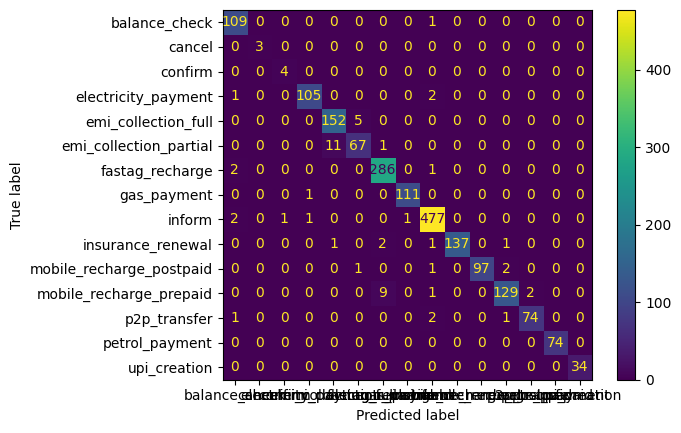

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

predictions = clf_list[0].predict(X_test)
X_test['predictions'] = predictions
# ConfusionMatrixDisplay.from_estimator(clf_list[1], X_test, y_test)
# cm = confusion_matrix(y_test, predictions, labels=clf_list[3].classes_)
ConfusionMatrixDisplay.from_predictions(y_test, predictions)

plt.show()

In [ ]:
test_analysis = data.loc[y_test.index, ['sentence', 'intent', 'language']]
print(test_analysis.shape)
test_analysis = pd.concat([test_analysis, X_test.predictions], axis=1)
test_analysis.shape

NameError: name 'data' is not defined

In [ ]:
# test_analysis.loc[2370, 'sentence']
# display(test_analysis)

In [ ]:
# print(test_analysis[(test_analysis.intent != test_analysis.predictions)].shape)
# test_analysis[(test_analysis.intent != test_analysis.predictions) & (test_analysis.intent == 'mobile_recharge_prepaid')]

In [ ]:
# clf_list[0].classes_

In [ ]:
# from sklearn.metrics import classification_report
# from sklearn.metrics import f1_score

# print(classification_report(y_test, predictions))
# f1_score(y_test, predictions, average='macro')

### RandomForest

In [ ]:
predictions = pipe.predict(X_test)
test_df = df.loc[y_test.index, ["Text","intent"]]
test_df["pred"] = predictions
display(test_df.head())
test_df.loc[test_df.intent != test_df.pred]

In [ ]:
# save the model
# from joblib import dump
# dump(pipe, 'sc_pca_rf.joblib')
# clf = load('sc_pca_rf.joblib')